save embeddings
run with bigrams
compare embeddings across

In [564]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import numpy as np
from numpy.linalg import norm

import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from sklearn.decomposition import PCA


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexanderkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderkumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [565]:
# glove2word2vec("../models/glove.6B/glove.6B.100d.txt", "../models/glove.6B/glove_6B_100d_model.txt")

In [566]:
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.last_loss = 0
        self.total_losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {}'.format(self.epoch, loss-self.last_loss))
        self.total_losses.append(loss-self.last_loss)
        self.last_loss = loss
        self.epoch += 1
        
        if self.epoch == 99: self.plot()
    
    def plot(self):
        plt.plot( list(range(1, self.epoch+1)),  self.total_losses)
        plt.title("Loss Over Training")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()
    
    

In [567]:
def most_similar(wv, keywords=["israel", "palestine", "gaza", "hamas"]):
    for word in keywords:
        print(f"Words most similar to {word}: ", 
            wv.most_similar(positive=[word], topn=10))
    
    return

In [568]:
def compare_relations(pre, post, word):
    pre_rel = pre.most_similar(positive=[word], topn=5)
    post_rel = post.most_similar(positive=[word], topn=5)
    print(f"Pretrained Embeddings Most Similar to {word}: ", pre_rel)
    print(f"Finetuned Embeddings Most Similar to {word}: ", post_rel)
    
    return

In [569]:
PAD_INDEX = 0
UNK_INDEX = 1
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
STOP_WORDS = set(stopwords.words('english'))
TOKENIZER = RegexpTokenizer(r'\w+')
LEMMATIZER = WordNetLemmatizer()
DIM = 100
EPOCHS = 100
RETAIN = 0.005

experiment = 'nyt_oct_3'
exp_title = 'NYT Oct'
filename = '../data/NYT_text_data_cleaned.csv'
pretrained_path = f"../models/glove.6B/glove_6B_{DIM}d_model.txt"
data = pd.read_csv(filename)
data = list(data['full_text'])
model_name = f'../models/{experiment}.model'
plot_name = f'../vis/{experiment}'
txt_name = f'../vis/{experiment}_changed.csv'

In [570]:
# # method 1: general
# cleaned_data = []
# for line in data:
#     sents = nltk.sent_tokenize(line)
#     sents = [sent.lower() for sent in sents]
#     tknzed_sents = [nltk.word_tokenize(sent) for sent in sents]
#     cleaned_data = cleaned_data + tknzed_sents

In [571]:
# method 2: clean punkt
cleaned_data = []
for line in data:
    sents = nltk.sent_tokenize(line)
    for sent in sents:
        words = sent.split(' ')
        clean_sent = []
        for word in words:
            word = TOKENIZER.tokenize(word.lower())
            for w in word:
                if w not in STOP_WORDS:
                    w = LEMMATIZER.lemmatize(w)
                    clean_sent.append(w)
    
        cleaned_data.append(clean_sent)

KeyboardInterrupt: 

In [ ]:
# cleaned_data = []
# for line in data:
#     tokens = nltk.wordpunct_tokenize(line)
#     text = nltk.Text(tokens)
#     words = [w.lower() for w in text if w.isalpha() and w not in STOP_WORDS]
#     cleaned_data.append(words)

In [ ]:
# cleaned_data = []
# for line in data:
#     line = line.replace('\xad', '')
#     line = line.translate(str.maketrans('', '', string.punctuation))
#     words = [w.lower() for w in line.split(' ') if w not in STOP_WORDS and w]
#     cleaned_data.append(words)

In [ ]:
# model = Word2Vec(vector_size=DIM, min_count=5)
model = Word2Vec(size=DIM, min_count=5)

model.build_vocab(cleaned_data)
total_examples = model.corpus_count

# Save the vocab of your dataset
# vocab = list(model.wv.index_to_key)
vocab = list(model.wv.vocab.keys())

In [ ]:
model_pre = KeyedVectors.load_word2vec_format(pretrained_path, binary=False)

new_words = [k for k in vocab if k not in model_pre]

# Add the pre-trained model vocabulary
model.build_vocab([list(model_pre.vocab.keys())], update=True)

# Load the pre-trained models embeddings
# note: if a word doesn't exist in the pre-trained vocabulary then it is left as is in the original model
model.intersect_word2vec_format(pretrained_path, binary=False, lockf=RETAIN)

In [ ]:
pre_word_embeddings = np.array([ model.wv[k] if k in model.wv else np.zeros(100) for k in vocab ]).copy()

Loss after epoch 0: 151375.71875
Loss after epoch 1: 157803.28125
Loss after epoch 2: 149161.71875
Loss after epoch 3: 147066.28125
Loss after epoch 4: 123616.5625
Loss after epoch 5: 120265.8125
Loss after epoch 6: 136922.0
Loss after epoch 7: 134515.125
Loss after epoch 8: 133088.0
Loss after epoch 9: 129199.25
Loss after epoch 10: 128974.5
Loss after epoch 11: 127877.375
Loss after epoch 12: 125504.375
Loss after epoch 13: 124460.5
Loss after epoch 14: 105970.5
Loss after epoch 15: 122576.25
Loss after epoch 16: 116985.25
Loss after epoch 17: 116789.5
Loss after epoch 18: 99087.5
Loss after epoch 19: 114736.25
Loss after epoch 20: 114475.25
Loss after epoch 21: 95911.25
Loss after epoch 22: 112552.75
Loss after epoch 23: 111705.25
Loss after epoch 24: 112563.5
Loss after epoch 25: 95156.5
Loss after epoch 26: 110239.0
Loss after epoch 27: 110287.75
Loss after epoch 28: 109859.25
Loss after epoch 29: 110302.75
Loss after epoch 30: 108857.75
Loss after epoch 31: 93348.75
Loss after ep

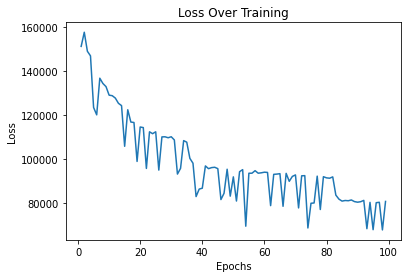

Loss after epoch 99: 70390.0


In [ ]:
model.train(cleaned_data, total_examples=total_examples, epochs=EPOCHS,
            compute_loss=True, callbacks=[callback()])
model.save(model_name)

In [ ]:
print("\nPretrained: ")
most_similar(model_pre)

print("\nFine tuned: ")
most_similar(model.wv)


Pretrained: 
Words most similar to israel:  [('israeli', 0.8549681901931763), ('palestinians', 0.8094196915626526), ('palestinian', 0.784780740737915), ('lebanon', 0.7811505794525146), ('syria', 0.7781013250350952), ('israelis', 0.7683233022689819), ('jerusalem', 0.7669271230697632), ('gaza', 0.7554309368133545), ('netanyahu', 0.732354462146759), ('arafat', 0.731320321559906)]
Words most similar to palestine:  [('israel', 0.6973910331726074), ('plo', 0.693358302116394), ('arab', 0.6852166652679443), ('jerusalem', 0.6812675595283508), ('lebanon', 0.6729379296302795), ('liberation', 0.6673558950424194), ('palestinian', 0.6671944856643677), ('territories', 0.6560360193252563), ('syria', 0.6443147659301758), ('gaza', 0.6302660703659058)]
Words most similar to gaza:  [('palestinian', 0.8426833748817444), ('palestinians', 0.8025381565093994), ('strip', 0.7997498512268066), ('rafah', 0.7923834919929504), ('hamas', 0.7923679351806641), ('israeli', 0.769335150718689), ('ramallah', 0.7555270195

In [ ]:
word_embeddings = np.array([ model.wv[k] if k in model.wv else np.zeros(100) for k in vocab ]).copy()

In [ ]:
reducer = umap.UMAP()
# embedding2d = reducer.fit_transform(word_embeddings)

scaled_we = StandardScaler().fit_transform(word_embeddings)
scaled_we_pre = StandardScaler().fit_transform(pre_word_embeddings)
embedding2d = reducer.fit_transform(scaled_we)
pre_embedding2d = reducer.fit_transform(scaled_we_pre)

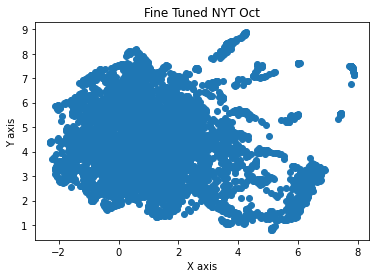

In [ ]:
plt.scatter(
    embedding2d[:, 0],
    embedding2d[:, 1])
plt.title(f'Fine Tuned {exp_title}')
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.savefig(plot_name + '_2d.png')

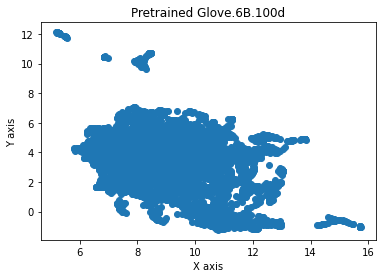

In [ ]:
plt.scatter(
    pre_embedding2d[:, 0],
    pre_embedding2d[:, 1])
plt.title(f'Pretrained Glove.6B.{DIM}d')
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.savefig(f'../vis/glove-6B-{DIM}d' + '_2d.png')

In [ ]:
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(word_embeddings)

x, y, z = zip(*reduced_embeddings)

# Create a 3D scatter plot using Plotly
scatter = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color='red'), text=vocab)

layout = go.Layout(scene=dict(xaxis=dict(title='X Label'), yaxis=dict(title='Y Label'), zaxis=dict(title='Z Label')))

fig = go.Figure(data=[scatter], layout=layout)

# Show the interactive plot in a Jupyter Notebook
fig.show()

fig.write_html(plot_name + "_3d.html")

KeyboardInterrupt: 

In [ ]:
pre_reduced_embeddings = pca.fit_transform(pre_word_embeddings)

x, y, z = zip(*pre_reduced_embeddings)

# Create a 3D scatter plot using Plotly
scatter = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color='red'), text=vocab)

layout = go.Layout(scene=dict(xaxis=dict(title='X Label'), yaxis=dict(title='Y Label'), zaxis=dict(title='Z Label')))

fig = go.Figure(data=[scatter], layout=layout)

# Show the interactive plot in a Jupyter Notebook
fig.show()
fig.write_html(f'../vis/glove-6B-{DIM}d' + "_3d.html")

KeyboardInterrupt: 

In [ ]:
for word, _ in list(distances.items())[: 10]:
    print(word)
    compare_relations(model_pre, model.wv, word)

palestinian
Pretrained Embeddings Most Similar to palestinian:  [('israeli', 0.8842455744743347), ('palestinians', 0.8787567615509033), ('gaza', 0.8426833748817444), ('hamas', 0.830059826374054), ('arafat', 0.7853145599365234)]
Finetuned Embeddings Most Similar to palestinian:  [('israeli', 0.8120347857475281), ('gaza', 0.7239096164703369), ('hamas', 0.7055630683898926), ('lebanese', 0.6993468999862671), ('plo', 0.6895391941070557)]
israel
Pretrained Embeddings Most Similar to israel:  [('israeli', 0.8549681901931763), ('palestinians', 0.8094196915626526), ('palestinian', 0.784780740737915), ('lebanon', 0.7811505794525146), ('syria', 0.7781013250350952)]
Finetuned Embeddings Most Similar to israel:  [('israeli', 0.7681593894958496), ('netanyahu', 0.7044255137443542), ('syria', 0.7014702558517456), ('lebanon', 0.6902516484260559), ('palestinian', 0.6593629121780396)]
gaza
Pretrained Embeddings Most Similar to gaza:  [('palestinian', 0.8426833748817444), ('palestinians', 0.80253815650939